# Poor_Att:

Date:23/01/23

This file contains functions related to the handling of data to identify those students with a very poor attendance record. The functions include, creating a list like table highlighting the various Student ID's as well as functions to produce visualisaitons to better compare a students attendance and the modules average.

___Note may have to run 'menu.ipynb' intially due to odd error in packages loading___

## Imports 

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from pathlib import Path
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as mcolours
import ipynb
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import seaborn as sns
from ipynb.fs.defs.CW_Preprocessing import *
from ipynb.fs.defs.Student_Att import *
from ipynb.fs.defs.Module_Att import *
from matplotlib import pylab


## Functions 

### Table and Graph producing functions 

In [2]:
class PoorAtt:
    
    
    def join_student_sess_data(student_att, semester, session_att):
        """
        Formats and renames, dataframe while filtering via semester input. This function is later used with 'sid_attendence' 
        to extract data from the SQL database to create a new dataframe.
        """
        student_att = student_att.transpose()
        student_att = student_att.reset_index()
        student_att = pd.DataFrame(student_att)
        student_att = student_att[1:]
        student_att = student_att.rename(columns={'index': 'session_id', 0 :'att'})
        student_att_merge = session_att.merge(student_att, on = "session_id", how = 'inner')
        student_att_merge = student_att_merge[student_att_merge['semester'] == semester]
        return(student_att_merge)

    
    def all_student_att_week_table(semester):
        """
        Function loops through every SID through 'sid_attendance' and creates a new dataframe including all SID's attendance
        which then undergo's a groupby 'week'. Producing a dataframe with weeeks as columns and all SID's by row.
        """
        complete_attendence = get_complete_attendence()
        complete_session = get_complete_session()
        all_student_att_week_df = pd.DataFrame() 
        for i in complete_attendence['sid']:
            students_att = sid_attendence(i)
            join_student_sess_df = PoorAtt.join_student_sess_data(students_att, semester, complete_session)
            filter_stu_sess = join_student_sess_df[['week', 'module', 'att']]
            pivot_stu_sess_df = filter_stu_sess.pivot_table(index = ['week','module'], aggfunc ='size')
            filter_stu_sess = filter_stu_sess.join(pivot_stu_sess_df.to_frame(), on = ['week','module'], how = 'outer')
            filter_stu_sess = filter_stu_sess.rename(columns={0 :'s_count'})
            filter_stu_sess = filter_stu_sess.groupby(['week'], as_index=True).agg({'att': 'sum', 's_count': 'count'})
            filter_stu_sess[i] = (filter_stu_sess['att'] / filter_stu_sess["s_count"] * 100)
            filter_stu_sess[i] = filter_stu_sess[i].replace(np.nan, 0)
            clean_stu_sess_df = filter_stu_sess.reset_index().pivot_table(values=i, columns="week")
            clean_stu_sess_df = clean_stu_sess_df.dropna(axis=1, how='all')
            clean_stu_sess_df.reset_index()
            all_student_att_week_df = pd.concat([all_student_att_week_df, clean_stu_sess_df])
        return(all_student_att_week_df)
    

    def full_clean_table(all_student_att_week_df):
        """
        Takes 'all_student_att_week_table' and applies a styled highlight, which highlights attendences in green when
        above or equal to the mean attendence.
        """
        clean_table = all_student_att_week_df.rename_axis('sid').reset_index()
        clean_table = clean_table.rename_axis(index=None, columns=None)
        clean_table = clean_table.rename(columns={'week': 'index',
                                                  1: 'Week 1',
                                                  2: 'Week 2',
                                                  3: 'Week 3',
                                                  4: 'Week 4',
                                                  5: 'Week 5',
                                                  6: 'Week 6',
                                                  7: 'Week 7'})
        clean_table['avg_att'] =  clean_table.iloc[:,1:].mean(axis=1).round()
        clean_table = clean_table.sort_values('avg_att',ascending=True)
        def highlight_max(att_pct):
            is_max = att_pct >= att_pct.mean()
            return ['background-color: #90EE90' if v else '' for v in is_max]
        clean_table = clean_table.style.apply(highlight_max, subset = ['Week 1',
                                                                       'Week 2',
                                                                       'Week 3',
                                                                       'Week 4',
                                                                       'Week 5',
                                                                       'Week 6'])
        return(clean_table)

    
    def select_style_table(clean_table):
        """
        Takes 'full_clean_table' and filters down the list to the SIDs that are 20% below the mean attendance. 
        It then highlights those with an attendance higher then the mean that week in green. 
        While those with a 0 attedence percentage in red.
        """
        style_table = clean_table.data
        style_table.loc['mean'] = style_table.mean()
        dfmean = style_table.loc[['mean']]
        dfmean.drop(columns=style_table.columns[[0,7]], axis=1,  inplace=True)
        filter_style_table = style_table[style_table['avg_att'] < (style_table['avg_att'].mean() * 0.8)]
        def bounded_highlights(filter_style_table):
            conds = [filter_style_table > dfmean.loc['mean'], filter_style_table == 0]
            labels = ['background-color: #90EE90', 'background-color: #FF5C5C']
            return np.select(conds, labels, default='')
        filter_style_table = filter_style_table.style.apply(bounded_highlights, subset = ['Week 1',
                                                                                          'Week 2',
                                                                                          'Week 3',
                                                                                          'Week 4',
                                                                                          'Week 5',
                                                                                          'Week 6'],
                                                            axis=1)
        return(filter_style_table)
    
    
    def all_module_att_week_table():
        """
        Completes an SQL query, joining the student attendance to the module session information. 
        The new dataframe is then groupby module and week, and the attendance percentage is calculated for each module.
        """
        csv = csv_data()
        merge_value = pd.DataFrame() 
        for i in csv.keys():
                att_pct_df = att_module(i)
                conn = sqlite3.connect('CWDatabase.db')
                session_table = "sql_" + i + "session"
                tablename = i + "_att"
                write_to_db(att_pct_df, tablename)
                sqlq = """SELECT {}.*, {}.num_att, {}.no_student, {}.att_pct
                   FROM {} INNER JOIN {}
                   ON {}.session_id = {}.session_id""".format(session_table,
                                                  "sql_" + tablename,
                                                  "sql_" + tablename,
                                                  "sql_" + tablename,
                                                  session_table,
                                                  "sql_" + tablename,
                                                  session_table,
                                                  "sql_" + tablename)
                sql_df = pd.read_sql(sqlq, conn)
                sql_df['semester'] = 1
                merge_value = pd.concat([merge_value, sql_df])
        all_module_att_week_df = merge_value.groupby(['module','week']).sum()
        all_module_att_week_df['att_pct'] = (all_module_att_week_df['num_att'] /
                                             all_module_att_week_df['no_student'] * 100).round()
        all_module_att_week_df = all_module_att_week_df.rename(columns={"semester": "no_sess",
                                                                        "num_att": "no_att"})
        return(all_module_att_week_df)

    
    def poor_att_table(semester):
        """
        Produces the PoorAtt table, function invovles the three steps to filter down to the selected group 20% below the
        average attendance percentage. Producing a styled table.
        """
        all_student_att_week_df = PoorAtt.all_student_att_week_table(semester)
        clean_table = PoorAtt.full_clean_table(all_student_att_week_df)
        filter_style_table = PoorAtt.select_style_table(clean_table)
        return(filter_style_table)
    
    
    def make_graph(*sid, semester):
        """
        Produces the PoorAtt graph, takes a tuple of SID's which are then looped so that the data can be plotted all on one 
        figure. Module attendance is also plotted on to this figure.
        """
        fig, ax = plt.subplots()
        for i in sid:
            sid_week_att = PoorAtt.full_clean_table(PoorAtt.all_student_att_week_table(semester)).data 
            mod_week_att = PoorAtt.all_module_att_week_table()
            filtered_sid_att = sid_week_att.loc[sid_week_att['sid']== i]
            student_modules = StudentAtt.merge_stuatt_compsess(i, semester)
            student_modules = StudentAtt.student_att_week_table(student_modules)
            student_modules = student_modules.columns.tolist()
            mod_week_att = mod_week_att.query('module in {}'.format(student_modules)) # Only plots modules which student are in.
            filtered_sid_att = filtered_sid_att.rename(columns={'Week 1': 1,
                                                                'Week 2' : 2,
                                                                'Week 3': 3,
                                                                'Week 4': 4,
                                                                'Week 5':5,
                                                                'Week 6': 6})
            filtered_sid_att = filtered_sid_att.transpose()
            filtered_sid_att = filtered_sid_att.rename(columns={filtered_sid_att.columns[0]:"att_pct"})
            filtered_sid_att.drop(filtered_sid_att.tail(1).index,inplace=True)
            filtered_sid_att.drop(filtered_sid_att.head(1).index,inplace=True)
            sns.scatterplot(y = "att_pct", x = filtered_sid_att.index, data = filtered_sid_att, ax = ax, label = i)
        sns.lineplot(x='week', y = 'att_pct', hue = 'module', data = mod_week_att, ax = ax, alpha = 0.6)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], title='Modules and SID', loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_ylabel('Attendance (%)')
        ax.set_xlabel('Week')
        ax.set_title('Comparing SID: {} weekly attendence to the Module average'.format(str(sid)[1:-1]))
        ax.plot()




## Testing 

In [3]:
def pooratt_dataframe_testing():
    """
    Testing pooratt dataframe creation functions
    """
    pooratt_test_dataframe = PoorAtt.all_student_att_week_table(1) # Semester = 1
    display(pooratt_test_dataframe) 

pooratt_dataframe_testing()

week,1,2,3,4,5,6
0,75.0,37.5,25.0,30.0,25.0,0.0
1,75.0,75.0,75.0,80.0,75.0,100.0
2,75.0,62.5,62.5,30.0,25.0,100.0
3,0.0,25.0,37.5,50.0,62.5,100.0
4,62.5,37.5,37.5,30.0,37.5,100.0
...,...,...,...,...,...,...
239,37.5,50.0,37.5,40.0,37.5,0.0
240,50.0,50.0,37.5,50.0,50.0,50.0
241,50.0,50.0,50.0,50.0,37.5,50.0
70,12.5,0.0,0.0,0.0,0.0,0.0


In [4]:
def pooratt_clean_dataframe_testing():
    """
    Testing pooratt dataframe cleaning functions
    """
    pooratt_test_dataframe = PoorAtt.all_student_att_week_table(1)
    pooratt_test_clean_dataframe = PoorAtt.full_clean_table(pooratt_test_dataframe)
    display(pooratt_test_clean_dataframe) 

pooratt_clean_dataframe_testing()

,sid,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,avg_att
192,70,12.500000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
137,169,0.000000,12.500000,0.000000,0.000000,0.000000,0.000000,2.000000
193,173,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
38,43,0.000000,12.500000,12.500000,0.000000,0.000000,0.000000,4.000000
140,175,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
21,24,12.500000,0.000000,0.000000,0.000000,12.500000,0.000000,4.000000
27,31,25.000000,12.500000,0.000000,0.000000,25.000000,0.000000,10.000000
37,42,25.000000,0.000000,12.500000,10.000000,25.000000,0.000000,12.000000
85,101,25.000000,12.500000,12.500000,20.000000,0.000000,0.000000,12.000000
93,111,0.000000,37.500000,25.000000,0.000000,12.500000,0.000000,12.000000


In [15]:
def pooratt_style_dataframe_testing():
    """
    Testing pooratt dataframe style functions
    """
    pooratt_test_dataframe = PoorAtt.all_student_att_week_table(1)
    pooratt_test_clean_dataframe = PoorAtt.full_clean_table(pooratt_test_dataframe)
    pooratt_test_style_dataframe = PoorAtt.select_style_table(pooratt_test_clean_dataframe)
    display(pooratt_test_style_dataframe) 

pooratt_style_dataframe_testing()

,sid,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,avg_att
192,70.000000,12.500000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
137,169.000000,0.000000,12.500000,0.000000,0.000000,0.000000,0.000000,2.000000
193,173.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
38,43.000000,0.000000,12.500000,12.500000,0.000000,0.000000,0.000000,4.000000
140,175.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
21,24.000000,12.500000,0.000000,0.000000,0.000000,12.500000,0.000000,4.000000
27,31.000000,25.000000,12.500000,0.000000,0.000000,25.000000,0.000000,10.000000
37,42.000000,25.000000,0.000000,12.500000,10.000000,25.000000,0.000000,12.000000
85,101.000000,25.000000,12.500000,12.500000,20.000000,0.000000,0.000000,12.000000
93,111.000000,0.000000,37.500000,25.000000,0.000000,12.500000,0.000000,12.000000


In [16]:
def pooratt_all_module_att_week_table_testing():
    """
    Testing pooratt creation of a complete module attendance table.
    """
    test_att_week_table = PoorAtt.all_module_att_week_table()
    display(test_att_week_table)

pooratt_all_module_att_week_table_testing()

/var/folders/v9/4j097t_s7v35q6l18rlpc8km0000gn/T/ipykernel_15848/3995912120.py:124: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_module_att_week_df = merge_value.groupby(['module','week']).sum()


no_sess  no_att  no_student  att_pct
module   week                                      
22COA111 1           2   269.0         382     70.0
         2           2   299.0         382     78.0
         3           2   276.0         382     72.0
         4           2   275.0         382     72.0
         5           2   276.0         382     72.0
22COA122 1           3   314.0         573     55.0
         2           3   280.0         573     49.0
         3           3   278.0         573     49.0
         4           4   396.0         764     52.0
         5           3   252.0         573     44.0
         6           1   152.0         191     80.0
22COA133 1           3    20.0          30     67.0
         2           3    16.0          30     53.0
         3           3    14.0          30     47.0
         4           4    20.0          40     50.0
         5           3    15.0          30     50.0
         6           1     8.0          10     80.0
22COA144 1           2   269.0         382     70.0
         2           2   299.0         382     78.0
         3           2   276.0         382     72.0
         4           2   275.0         382     72.0
         5           2   276.0         382     72.0

/var/folders/v9/4j097t_s7v35q6l18rlpc8km0000gn/T/ipykernel_15848/3995912120.py:124: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_module_att_week_df = merge_value.groupby(['module','week']).sum()
/var/folders/v9/4j097t_s7v35q6l18rlpc8km0000gn/T/ipykernel_15848/3995912120.py:124: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_module_att_week_df = merge_value.groupby(['module','week']).sum()
/var/folders/v9/4j097t_s7v35q6l18rlpc8km0000gn/T/ipykernel_15848/3995912120.py:124: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will defau

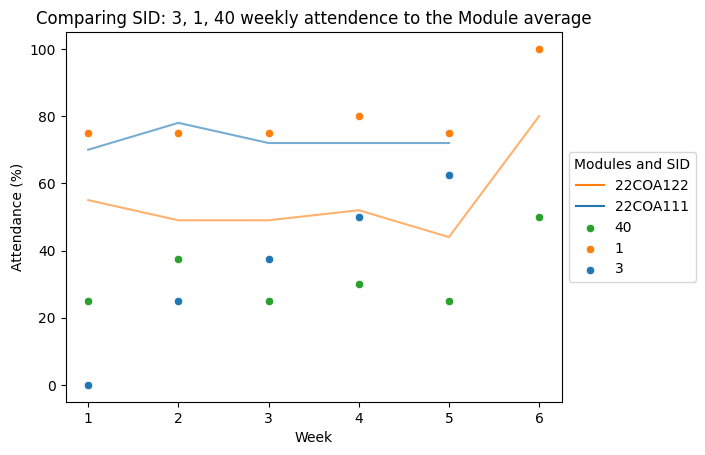

In [17]:
def pooratt_make_graph_testing():
    """
    Testing pooratt comparisson graph plotting. 
    """
    PoorAtt.make_graph(3,1,40, semester = 1) # SID = 3,1,40

pooratt_make_graph_testing()